# Supertrab - image preparation example
This notebook was created within the master project 'Revealing Trabecular Bone Architecture in 3D with Deep Learning based Super Resolution' refered to as Supertrab. The purpouse is to test methods for loading and processing CT images in the formats .mhd and .isq. Where the later are wwery large (>200Gb) and needs to be handles in sections of slices. 

Created on:  21.02.2025 <br />
Last update: 11.03.2025 <br />

- By: [Maja Wahlin](https://github.com/majwahP), 2025

---
## Aims
1. Load low resolution .mhd images and display
2. Load a selection of slices of high resolution images in .ISQ format using ISQmethods in this repository.
3. Process HR images with Caussian filter, remove air HU values and downsample with a factor of 2.
4. Save downsapled image in .mhd format - readable by more readers. 

---
# Configuration and Import

In [2]:
import os

import SimpleITK as sitk
import matplotlib.pyplot as plt


---
# Load Data

## Load LR-image

Load .mhd file

In [3]:

data_dir = "/usr/terminus/data-xrm-01/stamplab/users/mwahlin/2025/trab_master/CT pipeline" #base-path where .mhd and .raw file is located
mhd_file_path = os.path.join(data_dir, 'QCTFEMUR_1955L_R_HR.mhd')
#print(mhd_file_path)

mhd_image = sitk.ReadImage(mhd_file_path, imageIO="MetaImageIO")

### Display slice of image

Valid slice indices are 0 to 658


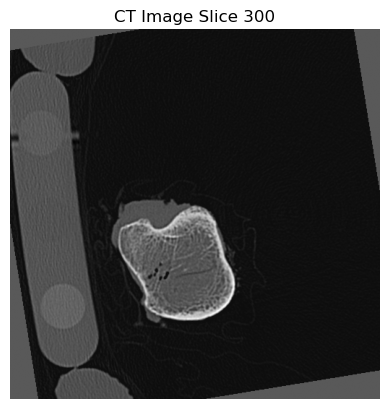

In [9]:
image_array = sitk.GetArrayFromImage(mhd_image)

print(f"Valid slice indices are 0 to {image_array.shape[0] - 1}")

if image_array.ndim == 3: # "slice dimension"
    slice_index = 300 # index of slice to show
    if slice_index < 0 or slice_index >= image_array.shape[0]:
        print("Slice index out of range; using middle slice instead.")
        slice_index = image_array.shape[0] // 2 #default mid-index
    image_slice = image_array[slice_index, :, :]
else:
    image_slice = image_array

# Display the image using matplotlib
plt.imshow(image_slice, cmap='gray')
plt.title(f'CT Image Slice {slice_index}')
plt.axis('off')
plt.show()

## Load HR-image

imports

In [54]:
import os
import sys
import SimpleITK as sitk

# import pyfabric
sys.path.append(os.path.abspath(".."))
from tests.ISQmethods import ISQload, readheader

#filtering and image processing
import numpy as np
from scipy.ndimage import gaussian_filter, zoom

Define file

In [55]:
#STORAGE - location of data
#image - file name in that location

STORAGE = "/usr/terminus/data-xrm-01/stamplab/external/tacosound/HR-pQCT_II/1955_L"
image = "C0001577.ISQ"

file_path = os.path.join(STORAGE, image)
print(file_path)

/usr/terminus/data-xrm-01/stamplab/external/tacosound/HR-pQCT_II/1955_L/C0001577.ISQ


Read header

In [56]:
ISQheader = readheader(file_path)
ISQheader

{'type': 'int16',
 'x_dim': 4608,
 'y_dim': 4608,
 'z_dim': 5921,
 'x_dim_um': 139622,
 'y_dim_um': 139622,
 'z_dim_um': 179406,
 'slice_thickness_um': 30,
 'slice_increment_um': 30,
 'slice_1_pos_um': 13575,
 'min_data_value': -31459,
 'max_data_value': 32767,
 'mu_scaling': 8192,
 'samplename': 'TaCoSound_1955_L',
 'energy': 68000,
 'intensity': 1470,
 'offset': 3584}

Read file

In [73]:
#change dims for chunks/selection of slices
image_data, ISQheader, filename = ISQload(os.path.join(STORAGE, image), x_min=0, y_min=0, z_min=4000, x_size=4608, y_size=4608, z_size=15)

Reading ISQ data...
 done!


Apply gaussian blur

In [74]:
sigma = 1.3
filtered_image_data = gaussian_filter(image_data, sigma=sigma)

examine data

(15, 4608, 4608)
(15, 4608, 4608)


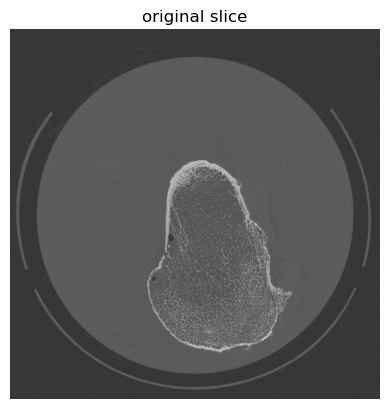

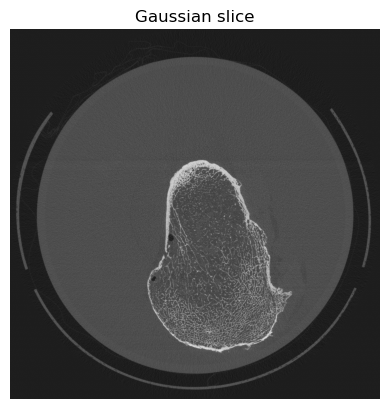

In [75]:
import matplotlib.pyplot as plt

print(image_data.shape)
print(filtered_image_data.shape)

slice_raw = image_data[5]
slice_gaussian = filtered_image_data[5]

# Display the slice
plt.imshow(slice_raw, cmap='gray')  
plt.title("original slice")
plt.axis("off") 
plt.show()

plt.imshow(slice_gaussian, cmap='gray')  
plt.title("Gaussian slice")
plt.axis("off") 
plt.show()

Removal of air values

In [76]:
modified_image_data = np.where(filtered_image_data < 1000, 2000, filtered_image_data)

examine data

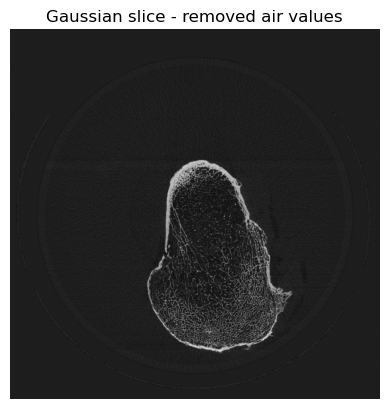

In [77]:
slice_modified = modified_image_data[5]

plt.imshow(slice_modified, cmap='gray')  
plt.title("Gaussian slice - removed air values")
plt.axis("off") 
plt.show()

Downsampling with linear interpolation

In [79]:
scale_factor = (1/2, 1/2, 1/2)
downsampled_image = zoom(modified_image_data, scale_factor, order=1)

print("Original shape:", modified_image_data.shape)
print("Downsampled shape:", downsampled_image.shape)

Original shape: (15, 4608, 4608)
Downsampled shape: (8, 2304, 2304)


Save processed image as .mha

In [66]:
sitk_image = sitk.GetImageFromArray(downsampled_image)

# Extract & Adjust Metadata from ISQheader
original_spacing = np.array([ISQheader["x_dim_um"] / ISQheader["x_dim"],
                             ISQheader["y_dim_um"] / ISQheader["y_dim"],
                             ISQheader["slice_thickness_um"]])

# Adjust spacing due to downsampling (factor 2)
new_spacing = original_spacing * 2  
sitk_image.SetSpacing(new_spacing.tolist())  # Convert to list for ITK compatibility

# Set Origin (Z position from ISQheader)
sitk_image.SetOrigin([0, 0, ISQheader["slice_1_pos_um"]])

# Add metadata from ISQheader
sitk_image.SetMetaData("samplename", ISQheader["samplename"])
sitk_image.SetMetaData("mu_scaling", str(ISQheader["mu_scaling"]))
sitk_image.SetMetaData("energy", str(ISQheader["energy"]))
sitk_image.SetMetaData("intensity", str(ISQheader["intensity"]))
sitk_image.SetMetaData("offset", str(ISQheader["offset"]))

# Save the processed image
data_dir = "/usr/terminus/data-xrm-01/stamplab/users/mwahlin/2025/trab_master/CT pipeline"
output_filename = os.path.basename(filename).replace(".ISQ", "_processed.mha")
output_filename = os.path.join(data_dir, output_filename)
sitk.WriteImage(sitk_image, output_filename)

print(f"Processed image saved as: {output_filename}")

Processed image saved as: /usr/terminus/data-xrm-01/stamplab/users/mwahlin/2025/trab_master/CT pipeline/C0001577_processed.mha


Examine the saved .mha file

Valid slice indices are 0 to 4


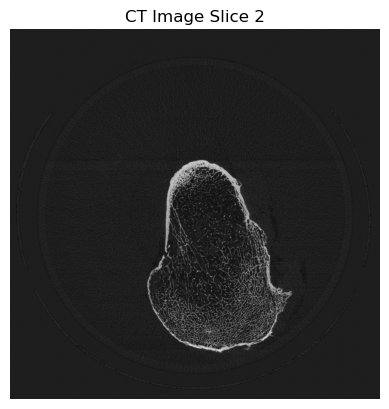

Image Size: (2304, 2304, 5)
Voxel Spacing: (60.599826388888886, 60.599826388888886, 60.0)
Origin: (0.0, 0.0, 13575.0)

🔹 Metadata:
ITK_InputFilterName: MetaImageIO
ITK_original_direction: [UNKNOWN_PRINT_CHARACTERISTICS]

ITK_original_spacing: [UNKNOWN_PRINT_CHARACTERISTICS]

Modality: MET_MOD_UNKNOWN
energy: 68000
intensity: 1470
mu_scaling: 8192
offset: 3584
samplename: TaCoSound_1955_L


In [72]:
data_dir = "/usr/terminus/data-xrm-01/stamplab/users/mwahlin/2025/trab_master/CT pipeline" #base-path where .mhd and .raw file is located
mha_file_path = os.path.join(data_dir, 'C0001577_processed.mha')
#print(mhd_file_path)

mha_image = sitk.ReadImage(mha_file_path, imageIO="MetaImageIO")

image_array = sitk.GetArrayFromImage(mha_image)

print(f"Valid slice indices are 0 to {image_array.shape[0] - 1}")

if image_array.ndim == 3: # "slice dimension"
    slice_index = 2 # index of slice to show
    if slice_index < 0 or slice_index >= image_array.shape[0]:
        print("Slice index out of range; using middle slice instead.")
        slice_index = image_array.shape[0] // 2 #default mid-index
    image_slice = image_array[slice_index, :, :]
else:
    image_slice = image_array

# Display the image using matplotlib
plt.imshow(image_slice, cmap='gray')
plt.title(f'CT Image Slice {slice_index}')
plt.axis('off')
plt.show()

print(f"Image Size: {mha_image.GetSize()}")  # (width, height, depth)
print(f"Voxel Spacing: {mha_image.GetSpacing()}")  # (x, y, z spacing)
print(f"Origin: {mha_image.GetOrigin()}")  # Image origin in world coordinates

print("\n🔹 Metadata:")
for key in mha_image.GetMetaDataKeys():
    print(f"{key}: {mha_image.GetMetaData(key)}")

---

Notebook created using the template of the ORMIR community (version 1.0, 2023)